In [3]:
import json
import os
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import dot
from numpy.linalg import norm
from resume_fields import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
# with open("parsed_resume_jsons/baseline_comparison.json", "r") as f:
#     baseline_comparison = json.load(f)

with open("new_baseline_comparison.json", "r") as f:
    baseline_comparison = json.load(f)
baseline = baseline_comparison["baseline"]
chatgpt = baseline_comparison["chatgpt"]
llama2 = baseline_comparison["llama2"]
keys = list(baseline.keys())

In [3]:
# keys_ = [x + '.txt' for x in keys]
# keys_

In [4]:
# with open("/Users/oscarwan/Research/CodeAndData/parsed_resume_jsons/parsed_resumes_llama2_current.json") as f:
#     llama2_all = json.load(f)
    
# with open("parsed_resume_jsons/new_chatgpt.json") as f:
#     chatgpt_all = json.load(f)
    
# with open("/Users/oscarwan/Research/CodeAndData/parsed_resume_jsons/new_chatgpt_failed.json") as f:
#     chatgpt_failed = json.load(f)
    
# with open("parsed_resume_jsons/llama2_failed.txt") as f:
#     llama2_failed = f.read().split("\n")
    
# with open("new_baseline_comparison.json", "r") as f:
#     new_baseline_comparison = json.load(f)

# available = [k for k in llama2_all.keys() if k not in llama2_failed and k not in chatgpt_failed and k in chatgpt_all.keys() and k not in keys_ and k not in new_baseline_comparison]
# import random
# chosen = random.choices(available, k=40)
# #a = baseline_comparison.copy()
# for c in chosen:
#     new_baseline_comparison['baseline'][c] = eval(res_format)
#     new_baseline_comparison['chatgpt'][c] = chatgpt_all[c]
#     new_baseline_comparison['llama2'][c] = llama2_all[c]
    

# # with open("new_baseline_comparison.json", "w") as f:
# #     json.dump(a, f, indent=4)
    
# len(new_baseline_comparison['baseline'].keys())

In [5]:
# with open("new_baseline_comparison.json", "w") as f:
#     json.dump(new_baseline_comparison, f, indent=4)

# Right or wrong answers: 
```
current_title
Job_Title
Company
Location
Start_Date
End_Date
```

# Metrics to use for experience description
```
Jaccard
cosine similarity
```

In [5]:
def compute_jaccard(text1, text2):
    # Tokenize the texts and convert to sets
    set1 = set(text1.split())
    set2 = set(text2.split())
    
    if not set1 and not set2:  # if both sets are empty
        return 1.0
    
    return len(set1.intersection(set2)) / len(set1.union(set2))


def cosine_similarity(vecA, vecB):
    if norm(vecA) == 0 or norm(vecB) == 0:
        return 0
    return dot(vecA, vecB) / (norm(vecA) * norm(vecB))

def compute_cosine_similarity(text1, text2):
    if len(text1.strip()) == 0 and len(text2.strip()) == 0:
        return 1
    elif len(text1.strip()) == 0 or len(text2.strip()) == 0:
        return 0
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    return cosine_similarity(vectorizer[0].toarray()[0], vectorizer[1].toarray()[0])
    

In [11]:
# get all "Responsibilities" fields in all resumes 
# for key in keys:
#     len_baseline = len(baseline[key][EXPERIENCE])
    
#     for k in len_baseline:
llama2_responsibilities = []
chatgpt_responsibilities = []
baseline_responsibilities = [job[RESPONSIBILITIES] for k in keys for job in baseline[k][EXPERIENCE]]
     
len_baseline_resps = [len(baseline[k][EXPERIENCE]) for k in keys]
for j in range(len(keys)):
    len_keys = len_baseline_resps[j]
    k = keys[j]
    if RESPONSIBILITIES in llama2[k][EXPERIENCE]:
        for ii in range(len_keys):
            if llama2[k][EXPERIENCE][ii]:
                llama2_responsibilities.append(llama2[k][EXPERIENCE][ii][RESPONSIBILITIES])
            else:
                llama2_responsibilities.append("")
    else:
        llama2_responsibilities.extend([""] * len_keys)
    
    if RESPONSIBILITIES in chatgpt[k][EXPERIENCE]:
        for ii in range(len_keys):
            if chatgpt[k][EXPERIENCE][ii]:
                chatgpt_responsibilities.append(chatgpt[k][EXPERIENCE][ii][RESPONSIBILITIES])
            else:
                chatgpt_responsibilities.append("")
    else:
        chatgpt_responsibilities.extend([""] * len_keys)

            
    

keys_ = [k for k in keys for job in chatgpt[k][EXPERIENCE]]
# also record the numner of words in each responsibility. Strip the leading and trailing spaces first, and all punctuations
llama_responsibilities_num_words = [len(job.strip().split()) for job in llama2_responsibilities]
chatgpt_responsibilities_num_words = [len(job.strip().split()) for job in chatgpt_responsibilities]
baseline_responsibilities_num_words = [len(job.strip().split()) for job in baseline_responsibilities]

llama_responsibilities_weights = [k / sum(baseline_responsibilities_num_words) for k in baseline_responsibilities_num_words]
chatgpt_responsibilities_weights = [k / sum(baseline_responsibilities_num_words) for k in baseline_responsibilities_num_words]

# check length of the responsibilities list are equal. print the lengths out
print(len(llama2_responsibilities), len(chatgpt_responsibilities), len(baseline_responsibilities))
assert len(llama2_responsibilities) == len(chatgpt_responsibilities) == len(baseline_responsibilities)


llama_vs_chatgpt = []
llama_vs_baseline = []
chatgpt_vs_baseline = []

for lr, cr, br in zip(llama_responsibilities, chatgpt_responsibilities, baseline_responsibilities):
    llama_vs_chatgpt.append(compute_cosine_similarity(lr, cr))
    llama_vs_baseline.append(compute_cosine_similarity(lr, br))
    chatgpt_vs_baseline.append(compute_cosine_similarity(cr, br))


llama_vs_chatgpt_jaccard = []
llama_vs_baseline_jaccard = []
chatgpt_vs_baseline_jaccard = []

for lr, cr, br in zip(llama_responsibilities, chatgpt_responsibilities, baseline_responsibilities):
    llama_vs_chatgpt_jaccard.append(compute_jaccard(lr, cr))
    llama_vs_baseline_jaccard.append(compute_jaccard(lr, br))
    chatgpt_vs_baseline_jaccard.append(compute_jaccard(cr, br))
    
cosine_similarity_df = pd.DataFrame({"Llama2_vs_baseline": llama_vs_baseline, 
                                     "Llama2_vs_chatgpt": llama_vs_chatgpt, 
                                     "ChatGPT_vs_baseline": chatgpt_vs_baseline})

jaccard_df = pd.DataFrame({"Llama2_vs_baseline": llama_vs_baseline_jaccard,
                            "Llama2_vs_chatgpt": llama_vs_chatgpt_jaccard,
                            "ChatGPT_vs_baseline": chatgpt_vs_baseline_jaccard})



[1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 0.7628693657641713,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 0.9947737061479625,
 0.9680556121845213,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0,
 0.983519903033299,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 0.7091263490863333,
 0.34236262353397845,
 0.9885835234996377,
 1.0000000000000002,
 0.0,
 0.9111530858595102,
 0.9996192858767488,
 0.9992557081649683,
 1.0000000000000002,
 0.8926208376320172,
 0.07360891948817685,
 0.979535269976528,
 0.9922087265310412,
 0.9981586303253359,
 0.9979401350508643,
 1.0,
 0.8266855260623603,
 0.9941770006186108,
 0.9991930751326822,
 0.9759640455776558,
 1.0000000000000002,
 1.0,
 0.9896055424875941,
 0.9858697808054288,
 1.0,
 0.9916971646334245,
 0.9172889878984923,
 1.0000000000000002,
 0.9975971674539865,
 0.9014288790264869,
 0.3910920054300662,
 1.0000000000000002,
 1.0000000000000002,
 0.9953685760733896,
 0.996809932412809,
 1.00000

In [8]:
cosine_similarity_df.describe()

,Llama2_vs_baseline,Llama2_vs_chatgpt,ChatGPT_vs_baseline
count,477.000000,477.0,477.000000
mean,0.016771,1.0,0.016771
std,0.128549,0.0,0.128549
min,0.000000,1.0,0.000000
25%,0.000000,1.0,0.000000
50%,0.000000,1.0,0.000000
75%,0.000000,1.0,0.000000
max,1.000000,1.0,1.000000


In [9]:
llama_weights = [len(lr.split()) for lr in llama2_responsibilities]
chatgpt_weights = [len(cr.split()) for cr in chatgpt_responsibilities]
baseline_weights = [len(br.split()) for br in baseline_responsibilities]

# Compute the weighted average for each pair
llama_vs_chatgpt_weighted_avg = sum(lc * lw for lc, lw in zip(llama_vs_chatgpt, llama_weights)) / sum(llama_weights)
llama_vs_baseline_weighted_avg = sum(lb * lw for lb, lw in zip(llama_vs_baseline, llama_weights)) / sum(llama_weights)
chatgpt_vs_baseline_weighted_avg = sum(cb * cw for cb, cw in zip(chatgpt_vs_baseline, chatgpt_weights)) / sum(chatgpt_weights)

# Print the results
print("Weighted Average of Cosine Similarities between Llama and ChatGPT:")
print(llama_vs_chatgpt_weighted_avg)

print("\nWeighted Average of Cosine Similarities between Llama and Baseline:")
print(llama_vs_baseline_weighted_avg)

print("\nWeighted Average of Cosine Similarities between ChatGPT and Baseline:")
print(chatgpt_vs_baseline_weighted_avg)

ZeroDivisionError: division by zero

In [12]:
results = {} 
for k in keys:
    results[k] = {
        'llama_vs_chatgpt': {
            'cosine_similarities': [],
            'jaccard_similarities': [],
            'weighted_avg_cosine': 0,
            'weighted_avg_jaccard': 0
        },
        'llama_vs_baseline': {
            'cosine_similarities': [],
            'jaccard_similarities': [],
            'weighted_avg_cosine': 0,
            'weighted_avg_jaccard': 0
        },
        'chatgpt_vs_baseline': {
            'cosine_similarities': [],
            'jaccard_similarities': [],
            'weighted_avg_cosine': 0,
            'weighted_avg_jaccard': 0
        }
    }
    
    chatgpt_exp = chatgpt[k]['Experience']
    llama2_exp = llama2[k]['Experience']
    baseline_exp = baseline[k]['Experience']
    
    # chatgpt_bio = chatgpt[k][BASIC_INFO][BIO]
    # llama2_bio = llama2[k][BASIC_INFO][BIO]
    # baseline_bio = baseline[k][BASIC_INFO][BIO]
    

    total_weight_llama_vs_chatgpt = 0
    total_weight_llama_vs_baseline = 0
    total_weight_chatgpt_vs_baseline = 0
    
    
    for cg, l2, bl in zip(chatgpt_exp, llama2_exp, baseline_exp):
        cg_resp = cg['Responsibilities']
        l2_resp = l2['Responsibilities'] if RESPONSIBILITIES in l2 else ""
        bl_resp = bl['Responsibilities']

        weight_cg = len(cg_resp.split())
        weight_l2 = len(l2_resp.split())
        weight_bl = len(bl_resp.split())

        # Calculate cosine similarities
        results[k]['llama_vs_chatgpt']['cosine_similarities'].append(compute_cosine_similarity(l2_resp, cg_resp))
        results[k]['llama_vs_baseline']['cosine_similarities'].append(compute_cosine_similarity(l2_resp, bl_resp))
        results[k]['chatgpt_vs_baseline']['cosine_similarities'].append(compute_cosine_similarity(cg_resp, bl_resp))

        # Calculate Jaccard similarities
        results[k]['llama_vs_chatgpt']['jaccard_similarities'].append(compute_jaccard(l2_resp, cg_resp))
        results[k]['llama_vs_baseline']['jaccard_similarities'].append(compute_jaccard(l2_resp, bl_resp))
        results[k]['chatgpt_vs_baseline']['jaccard_similarities'].append(compute_jaccard(cg_resp, bl_resp))

        # Update total weights
        total_weight_llama_vs_chatgpt += weight_l2
        total_weight_llama_vs_baseline += weight_l2
        total_weight_chatgpt_vs_baseline += weight_cg
    
    # # Calculate weighted averages for cosine similarity
    # results[k]['llama_vs_chatgpt']['weighted_avg_cosine'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['llama_vs_chatgpt']['cosine_similarities'], llama2_exp)) / total_weight_llama_vs_chatgpt
    # results[k]['llama_vs_baseline']['weighted_avg_cosine'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['llama_vs_baseline']['cosine_similarities'], llama2_exp)) / total_weight_llama_vs_baseline
    # results[k]['chatgpt_vs_baseline']['weighted_avg_cosine'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['chatgpt_vs_baseline']['cosine_similarities'], chatgpt_exp)) / total_weight_chatgpt_vs_baseline

    # # Calculate weighted averages for Jaccard similarity
    # results[k]['llama_vs_chatgpt']['weighted_avg_jaccard'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['llama_vs_chatgpt']['jaccard_similarities'], llama2_exp)) / total_weight_llama_vs_chatgpt
    # results[k]['llama_vs_baseline']['weighted_avg_jaccard'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['llama_vs_baseline']['jaccard_similarities'], llama2_exp)) / total_weight_llama_vs_baseline
    # results[k]['chatgpt_vs_baseline']['weighted_avg_jaccard'] = sum(sim * len(resp['Responsibilities'].split()) for sim, resp in zip(results[k]['chatgpt_vs_baseline']['jaccard_similarities'], chatgpt_exp)) / total_weight_chatgpt_vs_baseline
    
    # Calculate averages for cosine similarity
    results[k]['llama_vs_chatgpt']['weighted_avg_cosine'] = sum(results[k]['llama_vs_chatgpt']['cosine_similarities']) / len(results[k]['llama_vs_chatgpt']['cosine_similarities'])
    results[k]['llama_vs_baseline']['weighted_avg_cosine'] = sum(results[k]['llama_vs_baseline']['cosine_similarities']) / len(results[k]['llama_vs_baseline']['cosine_similarities'])
    results[k]['chatgpt_vs_baseline']['weighted_avg_cosine'] = sum(results[k]['chatgpt_vs_baseline']['cosine_similarities']) / len(results[k]['chatgpt_vs_baseline']['cosine_similarities'])
    


In [13]:
print(json.dumps(results, indent=4))

{
    "06552": {
        "llama_vs_chatgpt": {
            "cosine_similarities": [
                0.9042384632064859,
                0.9171861119498743,
                0.9552563039904772,
                0.9089586660367727
            ],
            "jaccard_similarities": [
                0.8444444444444444,
                0.875,
                0.8823529411764706,
                0.8604651162790697
            ],
            "weighted_avg_cosine": 0.9214098862959025,
            "weighted_avg_jaccard": 0
        },
        "llama_vs_baseline": {
            "cosine_similarities": [
                1.0000000000000002,
                1.0,
                1.0,
                1.0
            ],
            "jaccard_similarities": [
                1.0,
                1.0,
                1.0,
                1.0
            ],
            "weighted_avg_cosine": 1.0,
            "weighted_avg_jaccard": 0
        },
        "chatgpt_vs_baseline": {
            "cosine_similarities

In [14]:
results = {} 
for k in keys:
    results[k] = {
            RESPONSIBILITIES: {
                'llama_vs_chatgpt': {
                    'cosine_similarities': [],
                    'jaccard_similarities': [],
                    'weighted_avg_cosine': 0,
                    'weighted_avg_jaccard': 0,
                    'avg_cosine': 0,
                    'avg_jaccard': 0
                },
                'llama_vs_baseline': {
                    'cosine_similarities': [],
                    'jaccard_similarities': [],
                    'weighted_avg_cosine': 0,
                    'weighted_avg_jaccard': 0,
                    'avg_cosine': 0,
                    'avg_jaccard': 0
                },
                'chatgpt_vs_baseline': {
                    'cosine_similarities': [],
                    'jaccard_similarities': [],
                    'weighted_avg_cosine': 0,
                    'weighted_avg_jaccard': 0,
                    'avg_cosine': 0,
                    'avg_jaccard': 0
                }
            },
            
            BIO: {
                'llama_vs_chatgpt': {
                    'cosine_similarities': 0,
                    'jaccard_similarities': 0,
                },
                'llama_vs_baseline': {
                    'cosine_similarities': 0,
                    'jaccard_similarities': 0,
                },
                'chatgpt_vs_baseline': {
                    'cosine_similarities': 0,
                    'jaccard_similarities': 0,
                }
            }
    }
    
    chatgpt_exp = chatgpt[k]['Experience']
    llama2_exp = llama2[k]['Experience']
    baseline_exp = baseline[k]['Experience']
    
    chatgpt_bio = chatgpt[k][BASIC_INFO][BIO]
    llama2_bio = llama2[k][BASIC_INFO][BIO]
    baseline_bio = baseline[k][BASIC_INFO][BIO]
    
    
    # Calculate cosine similarities
    results[k][BIO]['llama_vs_chatgpt']['cosine_similarities'] = compute_cosine_similarity(llama2_bio, chatgpt_bio)
    results[k][BIO]['llama_vs_baseline']['cosine_similarities'] = compute_cosine_similarity(llama2_bio, baseline_bio)
    results[k][BIO]['chatgpt_vs_baseline']['cosine_similarities'] = compute_cosine_similarity(chatgpt_bio, baseline_bio)
    
    # Calculate Jaccard similarities
    results[k][BIO]['llama_vs_chatgpt']['jaccard_similarities'] = compute_jaccard(llama2_bio, chatgpt_bio)
    results[k][BIO]['llama_vs_baseline']['jaccard_similarities'] = compute_jaccard(llama2_bio, baseline_bio)
    results[k][BIO]['chatgpt_vs_baseline']['jaccard_similarities'] = compute_jaccard(chatgpt_bio, baseline_bio)


    total_weight_llama_chatgpt = 0
    total_weight_llama_baseline = 0
    total_weight_chatgpt_baseline = 0
    
    raw_cosine_llama_chatgpt = []
    raw_cosine_llama_baseline = []
    raw_cosine_chatgpt_baseline = []

    raw_jaccard_llama_chatgpt = []
    raw_jaccard_llama_baseline = []
    raw_jaccard_chatgpt_baseline = []

    
    
    for cg, l2, bl in zip(chatgpt_exp, llama2_exp, baseline_exp):
        cg_resp = cg['Responsibilities']
        l2_resp = l2['Responsibilities'] if RESPONSIBILITIES in l2 else ""
        bl_resp = bl['Responsibilities']

        weight_cg_l2 = len(bl_resp.split())
        weight_l2_bl = len(bl_resp.split())
        weight_cg_bl = len(bl_resp.split())
        
        # Update total weights
        total_weight_llama_chatgpt += weight_cg_l2
        total_weight_llama_baseline += weight_l2_bl
        total_weight_chatgpt_baseline += weight_cg_bl

        # Calculate cosine similarities
        cos_llama_chatgpt = compute_cosine_similarity(l2_resp, cg_resp)
        cos_llama_baseline = compute_cosine_similarity(l2_resp, bl_resp)
        cos_chatgpt_baseline = compute_cosine_similarity(cg_resp, bl_resp)

        # Calculate Jaccard similarities
        jacc_llama_chatgpt = compute_jaccard(l2_resp, cg_resp)
        jacc_llama_baseline = compute_jaccard(l2_resp, bl_resp)
        jacc_chatgpt_baseline = compute_jaccard(cg_resp, bl_resp)
        
        raw_cosine_llama_chatgpt.append(cos_llama_chatgpt)
        raw_cosine_llama_baseline.append(cos_llama_baseline)
        raw_cosine_chatgpt_baseline.append(cos_chatgpt_baseline)

        raw_jaccard_llama_chatgpt.append(jacc_llama_chatgpt)
        raw_jaccard_llama_baseline.append(jacc_llama_baseline)
        raw_jaccard_chatgpt_baseline.append(jacc_chatgpt_baseline)

        # Storing the weighted similarities
        results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['cosine_similarities'].append(cos_llama_chatgpt * weight_cg_l2)
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['cosine_similarities'].append(cos_llama_baseline * weight_l2_bl)
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['cosine_similarities'].append(cos_chatgpt_baseline * weight_cg_bl)

        results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['jaccard_similarities'].append(jacc_llama_chatgpt * weight_cg_l2)
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['jaccard_similarities'].append(jacc_llama_baseline * weight_l2_bl)
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['jaccard_similarities'].append(jacc_chatgpt_baseline * weight_cg_bl)

    # Compute the weighted averages
    results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['weighted_avg_cosine'] = sum(results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['cosine_similarities']) / total_weight_llama_chatgpt
    results[k][RESPONSIBILITIES]['llama_vs_baseline']['weighted_avg_cosine'] = sum(results[k][RESPONSIBILITIES]['llama_vs_baseline']['cosine_similarities']) / total_weight_llama_baseline
    results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['weighted_avg_cosine'] = sum(results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['cosine_similarities']) / total_weight_chatgpt_baseline

    results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['weighted_avg_jaccard'] = sum(results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['jaccard_similarities']) / total_weight_llama_chatgpt
    results[k][RESPONSIBILITIES]['llama_vs_baseline']['weighted_avg_jaccard'] = sum(results[k][RESPONSIBILITIES]['llama_vs_baseline']['jaccard_similarities']) / total_weight_llama_baseline
    results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['weighted_avg_jaccard'] = sum(results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['jaccard_similarities']) / total_weight_chatgpt_baseline
    
    results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['avg_cosine'] = sum(raw_cosine_llama_chatgpt) / len(raw_cosine_llama_chatgpt)
    results[k][RESPONSIBILITIES]['llama_vs_baseline']['avg_cosine'] = sum(raw_cosine_llama_baseline) / len(raw_cosine_llama_baseline)
    results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['avg_cosine'] = sum(raw_cosine_chatgpt_baseline) / len(raw_cosine_chatgpt_baseline)

    results[k][RESPONSIBILITIES]['llama_vs_chatgpt']['avg_jaccard'] = sum(raw_jaccard_llama_chatgpt) / len(raw_jaccard_llama_chatgpt)
    results[k][RESPONSIBILITIES]['llama_vs_baseline']['avg_jaccard'] = sum(raw_jaccard_llama_baseline) / len(raw_jaccard_llama_baseline)
    results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['avg_jaccard'] = sum(raw_jaccard_chatgpt_baseline) / len(raw_jaccard_chatgpt_baseline)


In [15]:
print(json.dumps(results, indent=4))

{
    "06552": {
        "Responsibilities": {
            "llama_vs_chatgpt": {
                "cosine_similarities": [
                    45.2119231603243,
                    50.44523615724309,
                    59.22589084740959,
                    44.538974635801864
                ],
                "jaccard_similarities": [
                    42.22222222222222,
                    48.125,
                    54.705882352941174,
                    42.16279069767442
                ],
                "weighted_avg_cosine": 0.9232501148184206,
                "weighted_avg_jaccard": 0.8667402558927676,
                "avg_cosine": 0.9214098862959025,
                "avg_jaccard": 0.8655656254749962
            },
            "llama_vs_baseline": {
                "cosine_similarities": [
                    50.000000000000014,
                    55.0,
                    62.0,
                    49.0
                ],
                "jaccard_similarities": [
          

In [17]:
chatgpt_responsibilities = [chatgpt[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for k in range(len(keys)) for i in range(len(chatgpt[keys[k]][EXPERIENCE]))]
llama2_responsibilities = [llama2[keys[k]][EXPERIENCE][i][RESPONSIBILITIES].replace("\ufffd", "").replace("- ", "") if RESPONSIBILITIES in llama2[keys[k]][EXPERIENCE][i] else "" for k in range(len(keys)) for i in range(len(llama2[keys[k]][EXPERIENCE]))]
baseline_responsibilities = [baseline[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for k in range(len(keys)) for i in range(len(baseline[keys[k]][EXPERIENCE]))]

llama2_responsibilities = [
    [llama2[keys[k]][EXPERIENCE][i][RESPONSIBILITIES].replace("\ufffd", "").replace("- ", "") if RESPONSIBILITIES in llama2[keys[k]][EXPERIENCE][i] else "" for i in range(len(llama2[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
chatgpt_responsibilities = [
    [chatgpt[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for i in range(len(chatgpt[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
baseline_responsibilities = [
    [baseline[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for i in range(len(baseline[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
assert len(llama2_responsibilities) == len(chatgpt_responsibilities) == len(baseline_responsibilities) == 118

llama2_responsibilities = [" ".join(llama2_responsibilities[i]) for i in range(len(llama2_responsibilities))]
chatgpt_responsibilities = [" ".join(chatgpt_responsibilities[i]) for i in range(len(chatgpt_responsibilities))]
baseline_responsibilities = [" ".join(baseline_responsibilities[i]) for i in range(len(baseline_responsibilities))]
assert len(llama2_responsibilities) == len(chatgpt_responsibilities) == len(baseline_responsibilities) == 118

llama2_cosine_similarity = [compute_cosine_similarity(llama2_responsibilities[i], baseline_responsibilities[i]) for i in range(len(llama2_responsibilities))]
chatgpt_cosine_similarity = [compute_cosine_similarity(chatgpt_responsibilities[i], baseline_responsibilities[i]) for i in range(len(chatgpt_responsibilities))]

llama2_jaccard_similarity = [compute_jaccard(llama2_responsibilities[i], baseline_responsibilities[i]) for i in range(len(llama2_responsibilities))]
chatgpt_jaccard_similarity = [compute_jaccard(chatgpt_responsibilities[i], baseline_responsibilities[i]) for i in range(len(chatgpt_responsibilities))]

weights = np.array([len(temp.split()) for temp in baseline_responsibilities])
weights = weights / weights.sum()

comparison_df = pd.DataFrame({"ChatGPT_cosine": chatgpt_cosine_similarity, "Llama2_cosine": llama2_cosine_similarity, "ChatGPT_jaccard": chatgpt_jaccard_similarity, "Llama2_jaccard": llama2_jaccard_similarity, "weights": weights})
comparison_df.to_csv("updated_lexical_comp.csv")

In [21]:
print(f"weighted average cosine similarity ChatGPT: {np.average(chatgpt_cosine_similarity, weights=weights)}")
print(f"weighted average cosine similarity Llama {np.average(llama2_cosine_similarity, weights=weights)}")
print()
print(f"weighted average jaccard similarity ChatGPT {np.average(chatgpt_jaccard_similarity, weights=weights)}")
print(f"weighted average jaccard similarity Llama2  {np.average(llama2_jaccard_similarity, weights=weights)}")

weighted average cosine similarity ChatGPT: 0.9799794269389799
weighted average cosine similarity Llama 0.9646297903500939

weighted average jaccard similarity ChatGPT 0.8904405746684989
weighted average jaccard similarity Llama2  0.8626487272979689


In [16]:
arrays = [
        ['avg_cosine', 'avg_cosine', 'avg_jaccard', 'avg_jaccard', 'weighted_avg_cosine', 'weighted_avg_cosine', 'weighted_avg_jaccard', 'weighted_avg_jaccard'],
        ['Llama_vs_Baseline', 'ChatGPT_vs_Baseline', 'Llama_vs_Baseline', 'ChatGPT_vs_Baseline', 'Llama_vs_Baseline', 'ChatGPT_vs_Baseline', 'Llama_vs_Baseline', 'ChatGPT_vs_Baseline']
    ]
columns = pd.MultiIndex.from_arrays(arrays)

df = pd.DataFrame(columns=columns)
for k in keys:
    df.loc[k] = [
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['avg_cosine'],
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['avg_cosine'],
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['avg_jaccard'],
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['avg_jaccard'],
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['weighted_avg_cosine'],
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['weighted_avg_cosine'],
        results[k][RESPONSIBILITIES]['llama_vs_baseline']['weighted_avg_jaccard'],
        results[k][RESPONSIBILITIES]['chatgpt_vs_baseline']['weighted_avg_jaccard']
    ]
    
df = df.round(3)
# get index of the lowest cosine similarity
#df['Llama_vs_Baseline']['avg_cosine'].idxmin()

In [17]:
# get indices of df['avg_cosine']['Llama_vs_Baseline'] that's less than 0.5
df[df['avg_cosine']['Llama_vs_Baseline'] < 0.5].index

Index(['16231', '20862', '21466', '12036', '01385.txt', '22443.txt',
       '13015.txt', '00014.txt'],
      dtype='object')

In [55]:
df['avg_cosine'].loc['01385.txt']

Llama_vs_Baseline      0.058
ChatGPT_vs_Baseline    1.000
Name: 12036, dtype: float64

In [62]:
chatgpt['01385.txt']['Experience']#[0]['Responsibilities']

[{'Job_Title': 'Senior MySQL and Oracle Database Administrator',
  'Company': 'VERIZON',
  'Location': 'Plano, TX',
  'Start_Date': 'January 2003',
  'End_Date': 'Present',
  'Responsibilities': 'Assigned to the fXO/Verizon Unix Database Administration team, responsible for the operation, maintenance, and performance tuning of all enterprise Oracle and MySQL databases- deployed in the Unix operating environment.- - Activities:- - Install, configure, and upgrade Oracle and MySQL databases and software on Solaris and Linux.- - Manage small, medium and large scale MySQL 5.6 - 8.0 instances where database size exceeds 1 TB.- - Interface with users and business units to resolve day to day issues, gather new requirements for new projects and capacity plan for future growth.- - Perform in-depth troubleshooting and provide consultation to systems administration and development teams.- - Establish, implement, and maintain sound backup and recovery policies and procedures using MySQL Enterprise-

In [61]:
baseline["01385.txt"]['Experience']

[{'Job_Title': 'Senior MySQL and Oracle Database Administrator',
  'Company': 'VERIZON',
  'Location': 'Plano, TX',
  'Start_Date': 'January 2003',
  'End_Date': 'Present',
  'Responsibilities': 'assigned to the fXO/Verizon Unix Database Administration team, responsible for the operation, maintenance, and performance tuning of all enterprise Oracle and MySQL databases- deployed in the Unix operating environment.'},
 {'Job_Title': 'Senior MySQL Database Consultant',
  'Company': 'FOUR CORNERSTONE',
  'Location': '',
  'Start_Date': '',
  'End_Date': 'Present',
  'Responsibilities': 'working with Four Cornerstone to provide MySQL consulting and database- administration services to current and future clients.'},
 {'Job_Title': 'Database Developer/ Administrator',
  'Company': 'ANCHOR ASSET MANAGEMENT',
  'Location': '',
  'Start_Date': 'February 2002',
  'End_Date': 'November 2002',
  'Responsibilities': 'responsible for the analysis, design, construction and testing of Financial Market S

In [63]:
compute_cosine_similarity(chatgpt['01385.txt']['Experience'][0]['Responsibilities'], baseline["01385.txt"]['Experience'][0]['Responsibilities'])

0.5691327513426463

In [44]:
getCleanResume('21466.txt')

"Software Architect and Developer \nSoftware Architect and \nDeveloper Trading Software Architect and Developer, C++, C#, Python, HFT, Hedge Fund New York, NY Authorized to work in the US for any employer Work Experience Software Architect and Developer Multiple companies, as well as self-employed April 1995 to Present Completed countless projects. Some are listed in my history on freelance marketplaces. Please see details at http://yuriygulyayev.x10host.com/Yuriy-Gulyayev-Consulting.html Education Master's in Computer Science National Technical University of Ukraine Kyiv September 1989 to February 1995 Skills .NET (10+ years), VISUAL STUDIO (10+ years), C# (10+ years), C++ (10+ years), HTML (1 year), JAVASCRIPT (1 year), BOOTSTRAP (1 year), JSON (3 years), .NET CORE (10+ years), Asp.Net (2 years), PYTHON (2 years), SOFTWARE DEVELOPMENT (10+ years), VISUAL BASIC .NET (5 years), VISUAL C++ (10+ years), XML (10+ years), SQL SERVER (2 years), CSS (1 year), MYSQL (1 year), C++/CLI (10+ yea

In [43]:
baseline["16231"]['Experience']

[{'Job_Title': 'Network Administrator',
  'Company': 'Magothy Computers & Telcom Solutions, LLC.',
  'Location': 'Severna Park, MD',
  'Start_Date': 'March 2004',
  'End_Date': 'Present',
  'Responsibilities': 'Supporting Small Businesses by understanding their technology goals, then designing and supporting a network infrastructure accordingly. Supporting diverse industries ranging from Milling and Machining to Medical, Accounting, and Real-estate companies. I have built their data systems to include file, print and mail servers supported by gigabit network backbones. This experience includes extensive server, desktop, laptop, tablet, and mobile support ranging in size from five to seventy-five node networks with a specialty in system security. Several of my sites are NIST-800-171 certified. Directly responsible for 20+ servers and analyzing each of the logs and maintaining each of their system structures. Maintain a proactive approach with infrastructure support thereby providing 99.

In [21]:
df.to_csv("metric_comparison.csv")

## weighted average cosine

In [22]:
descriptive = df.describe()
descriptive['weighted_avg_cosine']

,Llama_vs_Baseline,ChatGPT_vs_Baseline
count,118.000000,118.000000
mean,0.915771,0.954280
std,0.189028,0.126957
min,0.000000,0.099000
25%,0.950250,0.981250
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [23]:
descriptive['avg_cosine']

,Llama_vs_Baseline,ChatGPT_vs_Baseline
count,118.000000,118.000000
mean,0.906619,0.952695
std,0.195812,0.130116
min,0.000000,0.100000
25%,0.936750,0.982750
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Llama2 vs Baseline

In [24]:
df.sort_values(by=[('weighted_avg_cosine', 'Llama_vs_Baseline'), (('weighted_avg_cosine', 'ChatGPT_vs_Baseline'))], ascending=False)

avg_cosine                           avg_jaccard  \
          Llama_vs_Baseline ChatGPT_vs_Baseline Llama_vs_Baseline   
29524                 1.000                 1.0             1.000   
09328                 1.000                 1.0             1.000   
22094                 1.000                 1.0             0.769   
28241                 1.000                 1.0             1.000   
26375                 1.000                 1.0             0.971   
...                     ...                 ...               ...   
16231                 0.416                 1.0             0.054   
13015.txt             0.347                 1.0             0.111   
20862                 0.415                 1.0             0.317   
12036                 0.058                 1.0             0.023   
21466                 0.000                 1.0             0.000   

                              weighted_avg_cosine                      \
          ChatGPT_vs_Baseline   Llama_vs_Baseline ChatGPT_vs_Baseline   
29524                   1.000               1.000                 1.0   
09328                   0.981               1.000                 1.0   
22094                   1.000               1.000                 1.0   
28241                   0.980               1.000                 1.0   
26375                   0.861               1.000                 1.0   
...                       ...                 ...                 ...   
16231                   0.988               0.416                 1.0   
13015.txt               1.000               0.365                 1.0   
20862                   1.000               0.355                 1.0   
12036                   1.000               0.089                 1.0   
21466                   1.000               0.000                 1.0   

          weighted_avg_jaccard                      
             Llama_vs_Baseline ChatGPT_vs_Baseline  
29524                    1.000               1.000  
09328                    1.000               0.985  
22094                    0.776               1.000  
28241                    1.000               0.976  
26375                    0.970               0.861  
...                        ...                 ...  
16231                    0.054               0.983  
13015.txt                0.125               1.000  
20862                    0.258               1.000  
12036                    0.035               1.000  
21466                    0.000               1.000  

[118 rows x 8 columns]

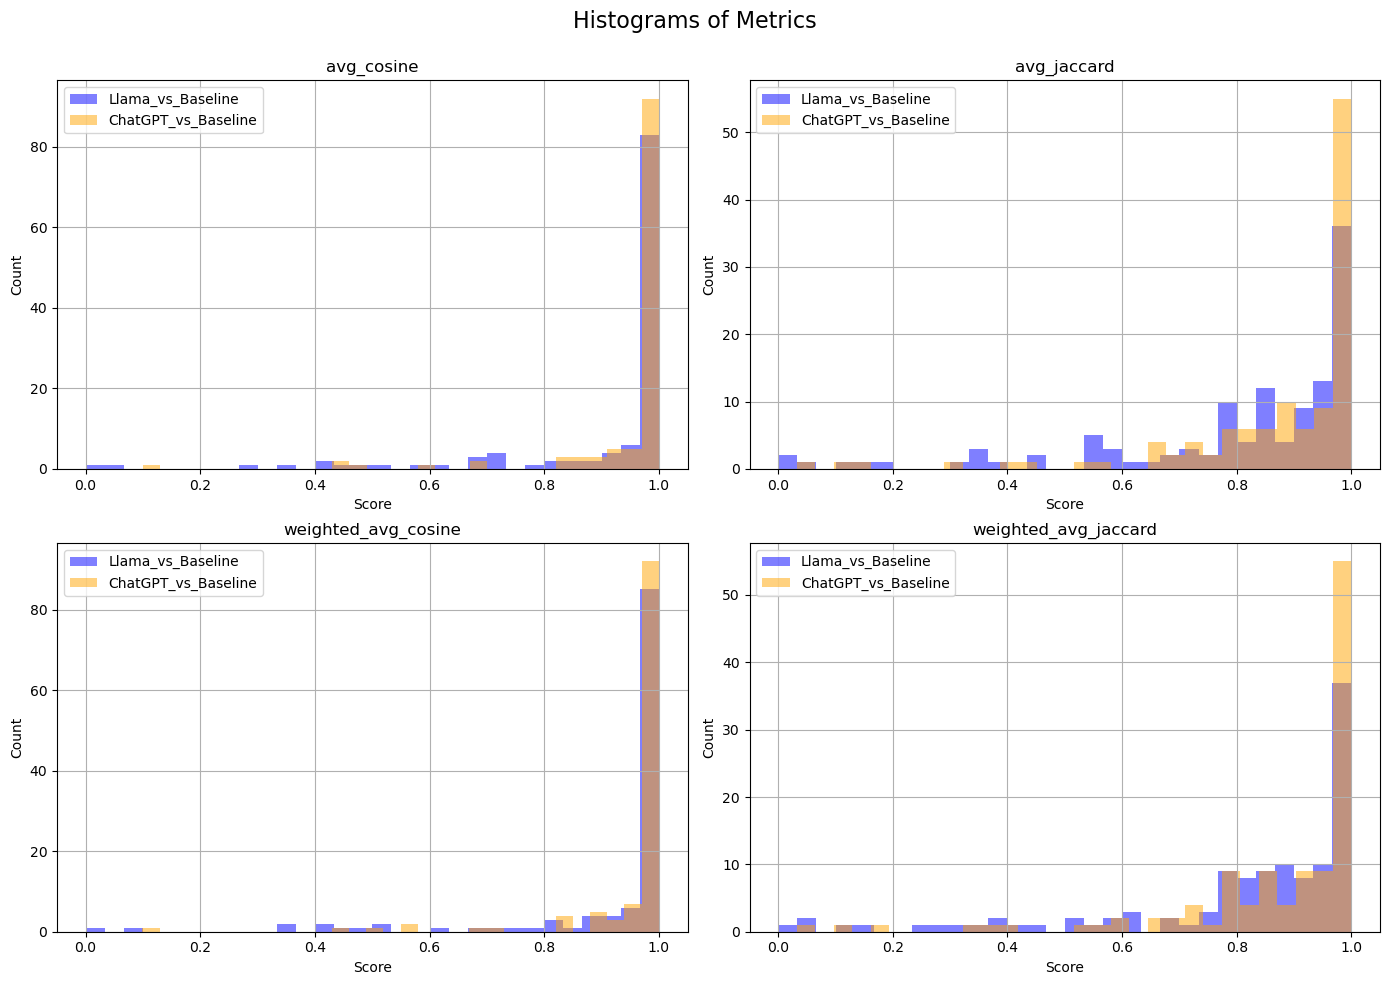

In [25]:
metrics = ['avg_cosine', 'avg_jaccard', 'weighted_avg_cosine', 'weighted_avg_jaccard']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for ax, metric in zip(axs.flatten(), metrics):
    df[metric]['Llama_vs_Baseline'].hist(alpha=0.5, bins=30, ax=ax, label='Llama_vs_Baseline', color='blue')
    df[metric]['ChatGPT_vs_Baseline'].hist(alpha=0.5, bins=30, ax=ax, label='ChatGPT_vs_Baseline', color='orange')
    ax.set_title(metric)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
fig.suptitle("Histograms of Metrics", fontsize=16)
fig.subplots_adjust(top=.91)
plt.savefig("distribution_of_lexical_metrics.png")
plt.show()

# Other fields in Experience and other right or wrong answers

In [10]:
accuracy = {}

for k in keys:
    truth = baseline[k][EXPERIENCE]
    llama2_exp  = llama2[k][EXPERIENCE]
    chatgpt_exp = chatgpt[k][EXPERIENCE]
    accuracy[k] = {"llama2": {}, "chatgpt": {}}
    for t, l, c in zip(truth, llama2_exp, chatgpt_exp):
        for field in list(t.keys())[:-1]:
            llama_field = l[field] if field in l else ""
            chatgpt_field = c[field] if field in c else ""
            
            accuracy[k]["llama2"][field] = llama_field == t[field]
            accuracy[k]["chatgpt"][field] = chatgpt_field == t[field]


## Other Right or wrong answers: 
```
current_title
Current_Company
bio
bio_location
```

In [11]:
for k in keys:
    truth = baseline[k][BASIC_INFO]
    llama2_exp  = llama2[k][BASIC_INFO]
    chatgpt_exp = chatgpt[k][BASIC_INFO]
    for field in list(truth.keys())[:-1]:
        if field == "Location":
            acc_field = "Current_Location"
        else:
            acc_field = field
        accuracy[k]["llama2"][acc_field] = llama2_exp[field] == truth[field]
        accuracy[k]["chatgpt"][acc_field] = chatgpt_exp[field] == truth[field]

In [13]:
model_acc = {"llama2": {k:[] for k in accuracy[keys[0]]["llama2"].keys()}, "chatgpt": {k:[] for k in accuracy[keys[0]]["chatgpt"].keys()}}
for _, res in accuracy.items():
    for model, result in res.items():
        for field, acc in result.items():
            model_acc[model][field].append(acc)

In [14]:
llama_acc = pd.DataFrame({k: [np.mean(v)] for k, v in model_acc["llama2"].items()})
chatgpt_acc = pd.DataFrame({k: [np.mean(v)] for k, v in model_acc["chatgpt"].items()})
model_acc_comparison = pd.concat([llama_acc, chatgpt_acc], axis=0)
model_acc_comparison.index = ["llama2", "chatgpt"]
model_acc_comparison = model_acc_comparison.T

In [15]:
model_acc_comparison["llama-chagpt"] = model_acc_comparison["llama2"] - model_acc_comparison["chatgpt"]

In [25]:
print(model_acc_comparison.round(3).iloc[:, :-1])

                  llama2  chatgpt
Job_Title          0.856    0.907
Company            0.864    0.898
Location           0.720    0.941
Start_Date         0.763    0.941
End_Date           0.746    0.949
Current_Title      0.924    0.924
Current_Company    0.703    0.644
Current_Location   0.881    0.873


In [ ]:
# 	llama2	chatgpt	llama-chagpt
# Job_Title	0.855932	0.906780	-0.050847
# Company	0.864407	0.898305	-0.033898
# Location	0.720339	0.940678	-0.220339
# Start_Date	0.762712	0.940678	-0.177966
# End_Date	0.745763	0.949153	-0.203390
# Current_Title	0.923729	0.923729	0.000000
# Current_Company	0.703390	0.644068	0.059322
# Current_Location	0.881356	0.872881	0.008475

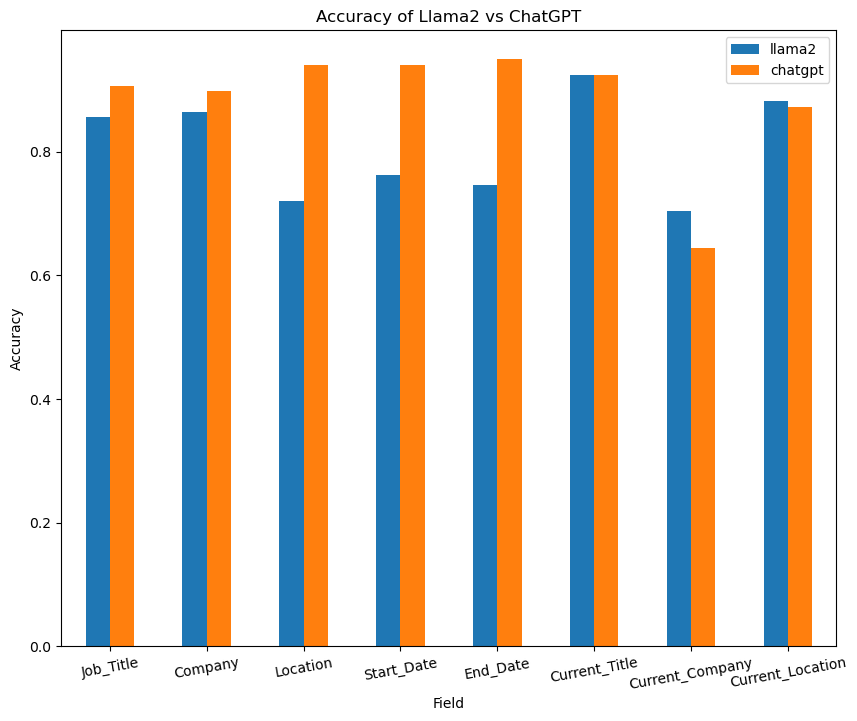

In [19]:
 # creat paired bar chart of model_acc_comparison excpet for the last column
fig, ax = plt.subplots(figsize=(10, 8))
model_acc_comparison.iloc[:, :-1].plot.bar(ax=ax)
ax.set_title("Accuracy of Llama2 vs ChatGPT")
ax.set_xlabel("Field")
ax.set_ylabel("Accuracy")

# tilt the x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(10)



# Skills

In [33]:
res = "07273"
print("LLAMA")
print(llama2[res][SKILLS] + llama2[res][TECHNICAL_SKILLS])
print()
print("ChatGPT")
print(chatgpt[res][SKILLS] + chatgpt[res][TECHNICAL_SKILLS])
print()
print("Baseline")
print(baseline[res][SKILLS] + baseline[res][TECHNICAL_SKILLS])


LLAMA
['Budgeting (Less than 1 year)', 'documentation. (Less than 1 year)', 'Forecasting (Less than 1 year)', 'Governance (Less than 1 year)', 'Program Management (Less than 1 year)']

ChatGPT
['Budgeting', 'Documentation', 'Forecasting', 'Governance', 'Program Management']

Baseline
['Budgeting', 'Documentation', 'Forecasting', 'Governance', 'Program Management']


In [34]:
for ii in chatgpt[res][SKILLS] + chatgpt[res][TECHNICAL_SKILLS]:
    print(ii)

Budgeting
Documentation
Forecasting
Governance
Program Management


In [35]:
len(llama2[res][SKILLS] + llama2[res][TECHNICAL_SKILLS])

5

In [36]:
getCleanResume("10423.txt")

"Malware Analyst Malware \nAnalyst Malware Analyst Lakewood, CO Work Experience Malware Analyst Booz Allen Hamilton McLean, VA May 2018 to March 2019 Worked proactively to prevent and contain malware infestation to protect client network and email integrity as well as proprietary data. Monitored and analyzed multiple clients email and network alerts by sandboxing and digging through logs Worked with clients to ensure their security needs are met Helped with black listing, whitelisting, and other needs of clients Junior Cyber Security Engineer Booz Allen Hamilton McLean, VA October 2016 to May 2018 Worked to improve logging in our SIEM and helped create better visibility across our network through McAfee ESM. Gained basic knowledge on creating alarms, correlation rules, fixing time deltas, and configuring our SIEM to best provide for the teams in the SOC. Developed a CMDB application of all systems in our environment through Swimlane to generate metrics on our SIEM environment for leade

In [37]:
baseline_comparison["baseline"][res][TECHNICAL_SKILLS] = llama2[res][SKILLS] + llama2[res][TECHNICAL_SKILLS]
baseline = baseline_comparison["baseline"]
chatgpt = baseline_comparison["chatgpt"]
llama2 = baseline_comparison["llama2"]
with open("parsed_resume_jsons/baseline_comparison.json", "w") as f:
    json.dump(baseline_comparison, f, indent=4)

In [28]:
chatgptSkills = chatgpt[keys[0]]["Skills"] + chatgpt[keys[0]]["Technical_Skills"]
llamaSkills = llama2[keys[0]]["Skills"] + llama2[keys[0]]["Technical_Skills"]
baselineSkills = baseline[keys[0]]["Skills"] + baseline[keys[0]]["Technical_Skills"]

skills = {key : {"llama2": set([x.upper() for x in llama2[key]['Skills'] + llama2[key]['Technical_Skills']]), "chatgpt": set([x.upper() for x in chatgpt[key]['Skills'] + chatgpt[key]['Technical_Skills']]), "baseline": set([x.upper() for x in baseline[key]['Skills'] + baseline[key]['Technical_Skills']])} for key in keys}

# for each model in "skills", calculate the length of the intersection between the skills of the model and the skills of the baseline
compute_iou = lambda x, y: len(x.intersection(y)) / len(x.union(y)) if x != y else 1
skills_iou = {key: {"llama2": compute_iou(skills[key]["llama2"], skills[key]["baseline"]), "chatgpt": compute_iou(skills[key]["chatgpt"], skills[key]["baseline"]), 'total_skills': len(skills[key]['baseline'])} for key in keys}
skills_iou = pd.DataFrame(skills_iou).T
skills_iou['weight'] = skills_iou['total_skills'] / skills_iou['total_skills'].sum()
skills_iou.describe()
skills_iou.to_csv("skills_iou.csv")

In [40]:
skills_iou.describe()

,llama2,chatgpt,total_skills,weight
count,118.000000,118.000000,118.000000,118.000000
mean,0.640278,0.622634,10.720339,0.008475
std,0.401522,0.422750,9.596016,0.007586
min,0.000000,0.000000,0.000000,0.000000
25%,0.210598,0.167187,4.000000,0.003162
50%,0.800000,0.899160,10.000000,0.007905
75%,1.000000,1.000000,14.750000,0.011660
max,1.000000,1.000000,48.000000,0.037945


In [ ]:
weighted_average_iou = (skills_iou['llama2'] * skills_iou['weight']).sum()

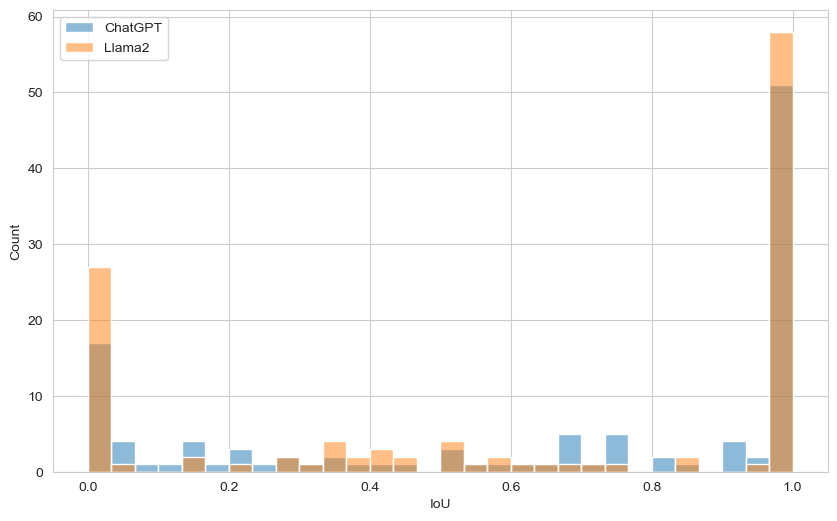

In [39]:

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(skills_iou['llama2'], bins=30, alpha = 0.5, label = "ChatGPT")
sns.histplot(skills_iou['chatgpt'], bins=30, alpha = 0.5, label = "Llama2")
plt.xlabel("IoU")
plt.legend()

In [41]:
llama_skills_weighetd_avg = skills_iou['llama2'] .dot(skills_iou['weight'])
chatgpt_skills_weighetd_avg = skills_iou['chatgpt'].dot(skills_iou['weight']) 
print(f"Llama IoU weighted average: {llama_skills_weighetd_avg}")
print(f"ChatGPT IoU weighted average: {chatgpt_skills_weighetd_avg}")

Llama IoU weighted average: 0.5821674463232058
ChatGPT IoU weighted average: 0.5446757733095491


In [43]:
skills_iou['weight'].values

array([0.00790514, 0.00632411, 0.00711462, 0.        , 0.00711462,
       0.01343874, 0.00316206, 0.00948617, 0.00869565, 0.00079051,
       0.01106719, 0.00869565, 0.        , 0.        , 0.00474308,
       0.0055336 , 0.01660079, 0.00395257, 0.01264822, 0.        ,
       0.00237154, 0.01027668, 0.        , 0.00395257, 0.00316206,
       0.0055336 , 0.0173913 , 0.02055336, 0.00395257, 0.        ,
       0.0055336 , 0.00237154, 0.        , 0.01106719, 0.01660079,
       0.0173913 , 0.        , 0.        , 0.00711462, 0.00316206,
       0.0055336 , 0.02213439, 0.00869565, 0.        , 0.01027668,
       0.01343874, 0.0055336 , 0.01027668, 0.        , 0.00948617,
       0.00869565, 0.01185771, 0.01422925, 0.00316206, 0.01027668,
       0.00395257, 0.00790514, 0.00395257, 0.00316206, 0.03003953,
       0.01660079, 0.01106719, 0.        , 0.00790514, 0.        ,
       0.00948617, 0.03794466, 0.00790514, 0.0173913 , 0.00869565,
       0.00395257, 0.00316206, 0.01422925, 0.00711462, 0.     